# 1. Import all the libraries and set the directory

In [1]:
# Mount the source of codes in the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make a path
%cd /content/drive/My Drive/Colab Notebooks/Assignment 2 CPC353/

/content/drive/My Drive/Colab Notebooks/Assignment 2 CPC353


In [3]:
# Import the libraries
import pandas as pd
import numpy as np
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input, concatenate 
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import load_model
from matplotlib.pyplot import figure

# 2. Word embedding created using GloVe

In [4]:
# Load the pre-trained embeddings from 
embeddings_index = {}
with open('GloVe.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [5]:
# Read in the training data
textEnglishTrain = pd.read_csv('train.en', header=None, names=['text']).astype(str)
textMalayTrain = pd.read_csv('train.my', header=None, names=['text']).astype(str)
textlabelsTrain = pd.read_csv('train.cl', header=None, names=['label'])

# 3. Tokenization of train data

In [7]:
# Tokenize English and Malay text
tokenizerEnglish = Tokenizer()
tokenizerEnglish.fit_on_texts(textEnglishTrain ['text'])
sequenceEnglish = tokenizerEnglish.texts_to_sequences(textEnglishTrain['text'])
tokenizerMalay = Tokenizer()
tokenizerMalay.fit_on_texts(textMalayTrain['text'])
sequenceMalay = tokenizerMalay.texts_to_sequences(textMalayTrain['text'])

# Pad the sequences
max_length = max(len(max(sequenceEnglish, key=len)), 
                 len(max(sequenceMalay, key=len)))
sequenceEnglish = pad_sequences(sequenceEnglish, maxlen=max_length)
sequenceMalay = pad_sequences(sequenceMalay, maxlen=max_length)

# Create the embedding layer
numWords = len(tokenizerEnglish.word_index) + 1
embeddingMatrix = np.zeros((numWords, 100))
for word, i in tokenizerEnglish.word_index.items():
  embeddingVector = embeddings_index.get(word)
  if embeddingVector is not None:
    embeddingMatrix[i] = embeddingVector
embeddingLayer = Embedding(numWords, 100, weights=[embeddingMatrix], 
                            input_length=max_length, trainable=False)

# Create the input layers
englishInput = Input(shape=(max_length,))
malayInput = Input(shape=(max_length,))
embeddedEnglish = embeddingLayer(englishInput)
embeddedMalay = embeddingLayer(malayInput)

# 4. LSTM model trained with 20 epoch

In [8]:
# Pass the embedded inputs through an LSTM layer
layerOfLSTM = LSTM(100)
outputEnglish = layerOfLSTM(embeddedEnglish)
outputMalay = layerOfLSTM(embeddedMalay)

# Concatenate the outputs and pass to dense layer
concatenated = concatenate([outputEnglish, outputMalay])
denseLayer = Dense(50, activation='relu')
concatenated = denseLayer(concatenated)

# Create the output layer and the model
outputLayer = Dense(1, activation='sigmoid')
output = outputLayer(concatenated)
model = Model(inputs=[englishInput, malayInput], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

# Create a checkpoint to save the best model
filepath = "weights_improve_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacksList = [checkpoint]

# Fit the model
history = model.fit([sequenceEnglish, sequenceMalay], 
                    textlabelsTrain, epochs=20, batch_size=32, validation_split=0.2, 
                    callbacks=callbacksList)

Epoch 1/20
3749/3750 [============================>.] - ETA: 0s - loss: 0.5034 - accuracy: 0.7506
Epoch 1: val_accuracy improved from -inf to 0.76440, saving model to weights_improve_01-0.76.hdf5
3750/3750 [==============================] - 64s 15ms/step - loss: 0.5034 - accuracy: 0.7506 - val_loss: 0.4843 - val_accuracy: 0.7644
Epoch 2/20
3749/3750 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8438
Epoch 2: val_accuracy improved from 0.76440 to 0.83010, saving model to weights_improve_02-0.83.hdf5
3750/3750 [==============================] - 55s 15ms/step - loss: 0.3614 - accuracy: 0.8438 - val_loss: 0.3859 - val_accuracy: 0.8301
Epoch 3/20
3746/3750 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8773
Epoch 3: val_accuracy improved from 0.83010 to 0.83297, saving model to weights_improve_03-0.83.hdf5
3750/3750 [==============================] - 51s 13ms/step - loss: 0.2936 - accuracy: 0.8773 - val_loss: 0.3810 - val_accuracy: 0.8330
E

# 5. Read the validation data and test data

In [9]:
# Read in the validation data
textValidEnglish = pd.read_csv('dev.en', header=None, names=['text']).astype(str)
textValidMalay = pd.read_csv('dev.my', header=None, names=['text']).astype(str)
textlabelValid = pd.read_csv('dev.cl', header=None, names=['label'])

# Tokenize the validation text and pad the sequences
englishValidSequence = tokenizerEnglish.texts_to_sequences(textValidEnglish['text'])
malayValidSequence = tokenizerMalay.texts_to_sequences(textValidMalay['text'])
englishValidSequence = pad_sequences(englishValidSequence, maxlen=max_length)
malayValidSequence = pad_sequences(malayValidSequence, maxlen=max_length)

# Evaluate the model on the validation data
validLoss, validAcc = model.evaluate([englishValidSequence, malayValidSequence], textlabelValid)
print('Validation Loss:', validLoss)
print('Validation Accuracy:', validAcc)

# Read in the test data
textEnglishTest = pd.read_csv('test.en', header=None, names=['text']).astype(str)
textMalayTest = pd.read_csv('test.my', header=None, names=['text']).astype(str)
textLabelTest = pd.read_csv('test.cl', header=None, names=['label'])

1436/1436 [==============================] - 10s 7ms/step - loss: 4.7833 - accuracy: 0.6173
Validation Loss: 4.783329963684082
Validation Accuracy: 0.6173307299613953


# 6. Tokenization of test data


In [10]:
# Tokenize the test text data and pad the sequences
testEnglishSequences = tokenizerEnglish.texts_to_sequences(textEnglishTest['text'])
testMalaySequences = tokenizerEnglish.texts_to_sequences(textMalayTest['text'])
testEnglishSequences = pad_sequences(testEnglishSequences, maxlen=max_length)
testMalaySequences = pad_sequences(testMalaySequences, maxlen=max_length)

# Evaluate the model on the test data
testLoss, testAcc = model.evaluate([testEnglishSequences, testMalaySequences], textLabelTest)
print('Test Loss:', testLoss)
print('Test Accuracy:', testAcc)

1250/1250 [==============================] - 9s 7ms/step - loss: 4.1568 - accuracy: 0.5235
Test Loss: 4.156802177429199
Test Accuracy: 0.5235499739646912


# 7. Load the best model

In [11]:
# Load the best model
bestModel = load_model('weights_improve_08-0.85.hdf5')

# Evaluate the best model on the test data
testLoss, testAcc = bestModel.evaluate([testEnglishSequences, testMalaySequences], textLabelTest)
print('Test Loss:', testLoss)
print('Test Accuracy:', testAcc)

1250/1250 [==============================] - 10s 7ms/step - loss: 1.6080 - accuracy: 0.5311
Test Loss: 1.60801100730896
Test Accuracy: 0.5310750007629395


# 8. Plot the graph of model accuracy and model loss

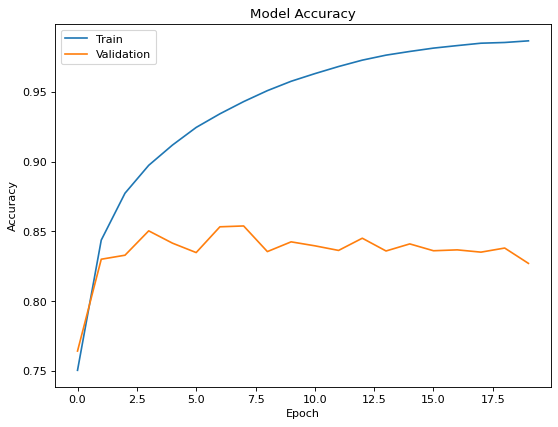

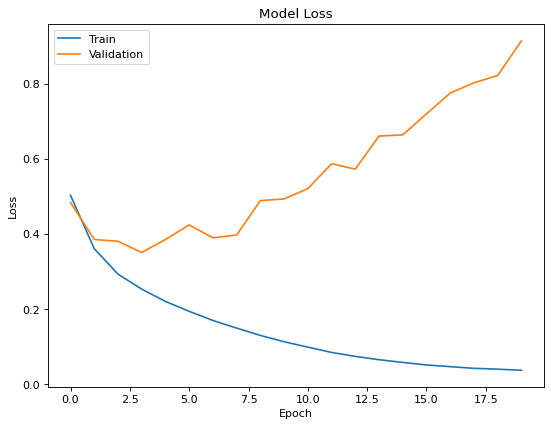

In [17]:
# Plot the training and validation accuracy
figure(figsize=(8, 6), dpi=80)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
figure(figsize=(8, 6), dpi=80)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()